##**About Dataset:**
This dataset is the result of web scraping the Rossmann website.
On main sites there are information about Brand, Name of the series of cream, Price, Links to direct sites of products.

From direct sites the lists of ingredients and short descriptions are downloaded.
Finally we get dataset split to columns:

* Link - link to direct product used as a 'https://www.rossmann.pl{link}',
* Brand - main producer of the product,
* Series - unique series of product or product line,
* Size - product capacity [ml],
* Price -normal price in PLN, sales are not included,
* Info - short description of the product,
* Ingredients - list of ingredients as type 'str' split by ', '


This dataset is collect using web scraping methods like  beautiful soup to collect useful records from website.

**FIRST MODEL**

I am going to analyze product based on several variables.

Then I build a model with the help of NLP techniques.

I will train the model on raw text without removing stop words and without regularization.
In my data the text is a short description of the product (the name of cream).

I will also create a model that matches the ingredients to the cream category.

 I will vizualize ingredients of creams using a word map.

**SECOND MODEL**

Manufacturers want to sell their products trying different ways to convince customers to buy their brand.

Whenever I want to buy a new face cream, it's so difficult to choose.  New items that I've never tried end up giving me skin trouble. We know the information we need is on the back of each product, but it's really hard to interpret those ingredients list unless you're a chemist:))
So instead of buying and hoping for the best, why don't we use data science to help us predict which products may be good fits for us and their price will be atractiv for us too.

I'm going to create a content-based recommendation system where the 'content' will be the chemical components of cosmetics and their price.  I will process ingredients list  face creams on Rossmann  via word embedding, then visualize ingredients similarity using a machine learning method called t-SNE and an interactive visualization library called Bokeh.
Additionally I will vizualize the similarity of  creams using a cluster hierarchy. 

##Importing dependencies

In [144]:
import pandas as pd
import numpy as np
import requests             
import re
from time import sleep     
import html                
import unicodedata         
from bs4 import BeautifulSoup

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer #builds TF-IDF

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
#word map
from os import path
from PIL import Image    #PIL - Python Imaging Library
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from sklearn.manifold import TSNE
from bokeh.io import show, output_notebook, push_notebook
from bokeh.plotting import figure, output_file, show, save
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.models.annotations import Title
output_notebook()


##Download data from main sites

In [2]:
def get_data(number_of_pages):
                                          
    all_data = []
    all_prices = []
    
    
    for page_number in range(1, number_of_pages+1):
        print(f'Getting data from page number {page_number}')
        
        http_address = f'https://www.rossmann.pl/kategoria/twarz/pielegnacja-twarzy/kremy-do-twarzy,9223?Page={page_number}&PageSize=96'
        response = requests.get(http_address)
        content = response.content.decode("utf-8")
        content = html.unescape(content)
        content = unicodedata.normalize('NFKD', content)
        soup = BeautifulSoup(content, 'html.parser')
        

        data = soup.find_all('a', {'class':'tile-product__name'})
        price = soup.find_all('div', {'class':'tile-product__price'})
        print(data, type(data))
        print(price, type(price))

        all_data.extend(data)
        all_prices.extend(price)

        
        sleep(5)

    print(len(all_data))
    print(len(all_prices))

    a = all_prices[0]
    all_prices = [i for i in all_prices if i != a]
    print(len(all_data))
    print(len(all_prices))


    df = pd.DataFrame([all_data, all_prices]).T
    
    return df

In [3]:
rossmann = get_data(6)

Getting data from page number 1
[<a class="tile-product__name" href="/Produkt/Kremy-do-twarzy/LOreal-Paris-Age-Perfect-Cell-Renew-krem-na-dzien-rewitalizujacy-SPF-30-50-ml,390632,9223"><strong>L'ORÉAL PARIS<!-- --> <!-- -->Age Perfect Cell Renew</strong><span>krem na dzień rewitalizujący, SPF 30, <span class="text-nowrap">50 ml</span></span></a>, <a class="tile-product__name" href="/Produkt/Kremy-do-twarzy/LOreal-Paris-Age-Perfect-Cell-Renew-krem-na-dzien-rewitalizujacy-50-ml,390629,9223"><strong>L'ORÉAL PARIS<!-- --> <!-- -->Age Perfect Cell Renew</strong><span>krem na dzień rewitalizujący, <span class="text-nowrap">50 ml</span></span></a>, <a class="tile-product__name" href="/Produkt/Kremy-do-twarzy/LOreal-Paris-Age-Perfect-Cell-Renew-krem-na-noc-regenerujacy-50-ml,390631,9223"><strong>L'ORÉAL PARIS<!-- --> <!-- -->Age Perfect Cell Renew</strong><span>krem na noc regenerujący, <span class="text-nowrap">50 ml</span></span></a>, <a class="tile-product__name" href="/Produkt/Krem

In [4]:
len(rossmann)

576

In [5]:
rossmann

,0,1
0,"[[L'ORÉAL PARIS, , , , Age Perfect Cell Re...","[[84,99 zł], [54,99 zł]]"
1,"[[L'ORÉAL PARIS, , , , Age Perfect Cell Re...","[[84,99 zł], [54,99 zł]]"
2,"[[L'ORÉAL PARIS, , , , Age Perfect Cell Re...","[[84,99 zł], [54,99 zł]]"
3,"[[CHRISTIAN LAURENT, , , , Edition de Luxe]...","[[67,99 zł]]"
4,"[[DERMIKA, , , , Luxury Caviar], [krem wype...","[[74,99 zł]]"
...,...,...
571,"[[VENUS, , , , Zalecana Receptura], [krem o...","[[11,99 zł], [8,99 zł]]"
572,"[[VENUS, , , , Zalecana Receptura], [napraw...","[[13,99 zł], [10,49 zł]]"
573,"[[VENUS, , , , Zalecana Receptura], [multif...","[[11,99 zł], [8,99 zł]]"
574,"[[JUMISO, , ], [nawilżający krem regeneruj...","[[84,99 zł]]"


In [6]:
type(rossmann[1][1].get_text())

str

In [ ]:
verification = []

for i in rossmann[1]:
  a = i.get_text()
  verification.append(a)

verification

In [8]:
type(rossmann[0])

pandas.core.series.Series

In [9]:
rossmann[0][1]

<a class="tile-product__name" href="/Produkt/Kremy-do-twarzy/LOreal-Paris-Age-Perfect-Cell-Renew-krem-na-dzien-rewitalizujacy-50-ml,390629,9223"><strong>L'ORÉAL PARIS<!-- --> <!-- -->Age Perfect Cell Renew</strong><span>krem na dzień rewitalizujący, <span class="text-nowrap">50 ml</span></span></a>

In [10]:
a = '31,99 zł18,99 zł'

In [11]:
b = (re.findall(r'.*?zł',str(a), re.DOTALL))[0]
b

'31,99 zł'

In [12]:
size = re.findall(r'class="text-nowrap">(\d\d.*?)</span>',str(rossmann[0][1]), re.DOTALL)
size

['50 ml']

#Split data to columns

In [13]:
def split_data(all_data):

  # split data to columns
  links = []
  companies = []
  descriptions = []
  prices = []
  sizes = []
  i = 0
  
  #
  for cream in all_data[0]:
    link = re.findall(r'href="(.*?)"><',str(cream), re.DOTALL)
    company = re.findall(r'<strong>(.*?)</strong>',str(cream), re.DOTALL)
    description = re.findall(r'<span>(.*?)<span',str(cream) , re.DOTALL)
    size = re.findall(r'class="text-nowrap">(\d.*?)</span>',str(cream), re.DOTALL)
    if not size:
      size = 'EMPTY'
    print(i, size)
    i += 1

    links.extend(link)
    companies.extend(company)
    descriptions.extend(description)
    sizes.extend(size)



  for money in all_data[1]:
    price = money.get_text()
    price = (re.findall(r'.*?zł',str(price), re.DOTALL))[0]
    # print(price)
    prices.append(str(price))


  #split company to brand and series
  print(len(links))
  print(len(companies))
  print(len(descriptions))
  print(len(prices))
  print(len(sizes))

  brand = []
  series = []
  a = []
  for i in range(len(companies)):
    a = companies[i].split('<!-- --> <!-- -->')

  #check which brands do not have series
    if len(a)<2:
      brand.append(a[0].replace('<!-- --> ',''))
      series.append('@NO_NAME@')
    else:
      # print(a, a[0], a[1])
      brand.append(a[0])
      series.append(a[1])

  #create df
  df_all_data = pd.DataFrame({'link':links, 
                              'brand':brand, 
                              'series':series,
                              'size':sizes, 
                              'price':prices,
                              'info':descriptions})

  return df_all_data

In [ ]:
df_ross = split_data(rossmann)

In [15]:
df_ross['size'][158]

'2x50 ml'

In [16]:
df_ross

,link,brand,series,size,price,info
0,/Produkt/Kremy-do-twarzy/LOreal-Paris-Age-Perf...,L'ORÉAL PARIS,Age Perfect Cell Renew,50 ml,"84,99 zł","krem na dzień rewitalizujący, SPF 30,"
1,/Produkt/Kremy-do-twarzy/LOreal-Paris-Age-Perf...,L'ORÉAL PARIS,Age Perfect Cell Renew,50 ml,"84,99 zł","krem na dzień rewitalizujący,"
2,/Produkt/Kremy-do-twarzy/LOreal-Paris-Age-Perf...,L'ORÉAL PARIS,Age Perfect Cell Renew,50 ml,"84,99 zł","krem na noc regenerujący,"
3,/Produkt/Kremy-do-twarzy/Christian-Laurent-Edi...,CHRISTIAN LAURENT,Edition de Luxe,50 ml,"67,99 zł",diamentowy krem ujędrniająco-odmładzający n...
4,/Produkt/Kremy-do-twarzy/Dermika-Luxury-Caviar...,DERMIKA,Luxury Caviar,50 ml,"74,99 zł",krem wypełniający zmarszczki na dzień i na n...
...,...,...,...,...,...,...
571,/Produkt/Kremy-do-twarzy/Venus-Zalecana-Recept...,VENUS,Zalecana Receptura,50 ml,"11,99 zł","krem ochronny skóra nadwrażliwa,"
572,/Produkt/Kremy-do-twarzy/Venus-Zalecana-Recept...,VENUS,Zalecana Receptura,50 ml,"13,99 zł",naprawczy krem na dzień i na noc skóra nadwr...
573,/Produkt/Kremy-do-twarzy/Venus-Zalecana-Recept...,VENUS,Zalecana Receptura,50 ml,"11,99 zł",multifunkcjonalny krem 3w1 na dzień i na noc ...
574,/Produkt/Kremy-do-twarzy/Jumiso-nawilzajacy-kr...,JUMISO,@NO_NAME@,50 ml,"84,99 zł",nawilżający krem regenerujący ze śluzu śl...


In [17]:
df_ross['link'][5]

'/Produkt/Kremy-do-twarzy/Dermika-Luxury-Caviar-krem-aktywnie-regenerujacy-na-dzien-i-na-noc-60-50-ml,381351,9223'

In [18]:
link = df_ross['link'][5]
http_address = f'https://www.rossmann.pl{link}'
response = requests.get(http_address)
content = response.content.decode("utf-8")
content = html.unescape(content)
content = unicodedata.normalize('NFKD', content)
soup = BeautifulSoup(content, 'html.parser')

In [ ]:
print(soup.prettify())

## Download data from direct sites

In [20]:
ingredients_list = []
ingredients = ''

for i in df_ross['link']:
  http_address = f'https://www.rossmann.pl{i}'
  response = requests.get(http_address)
  content = response.content.decode("utf-8")
  content = html.unescape(content)
  content = unicodedata.normalize('NFKD', content)
  soup = BeautifulSoup(content, 'html.parser')
  sleep(1)

  try:
    soup.find('div', {"class":"collapse fade py-2 "}).find('span', {"class":"csC8F6D76"}).get_text()
  except:
    ingredients_list.append('NO COMPOSITION - ERROR')
  else:
    ingredients = soup.find('div', {"class":"collapse fade py-2 "}).find('span', {"class":"csC8F6D76"}).get_text()
    ingredients_list.append(ingredients)

In [21]:
ingredients_list

['909193 12 – INGREDIENTS: AQUA / WATER • GLYCERIN • ETHYLHEXYL SALICYLATE • DIMETHICONE • OCTOCRYLENE • BUTYL METHOXYDIBENZOYLMETHANE • CETYL ALCOHOL • OCTYLDODECANOL • PHENYLBENZIMIDAZOLE SULFONIC ACID • ETHYLHEXYL TRIAZONE • BEHENYL ALCOHOL • ISOPROPYL ISOSTEARATE • TRIETHANOLAMINE • PERLITE • ALUMINUM STARCH OCTENYLSUCCINATE • LAUROYL LYSINE • TUBER AESTIVUM EXTRACT • TUBER MELANOSPORUM EXTRACT • ADENOSINE • CAPRYLOYL SALICYLIC ACID • HYDROXYACETOPHENONE • NEOHESPERIDIN DIHYDROCHALCONE • SACCHAROMYCES/XYLINUM/BLACK TEA FERMENT • SODIUM HYALURONATE • TRISODIUM ETHYLENEDIAMINE DISUCCINATE • TOCOPHEROL • ACRYLAMIDE/SODIUM ACRYLOYLDIMETHYLTAURATE COPOLYMER • AMMONIUM POLYACRYLOYLDIMETHYL TAURATE • BIOTIN • CETEARYL ALCOHOL • CETEARYL GLUCOSIDE • CITRIC ACID • DIMETHYL ISOSORBIDE • HYDROXYETHYL ACRYLATE/SODIUM ACRYLOYLDIMETHYL TAURATE COPOLYMER • HYDROXYETHYLCELLULOSE • ISOHEXADECANE • MYRISTIC ACID • PALMITIC ACID • PEG-100 STEARATE • POLY C10-30 ALKYL ACRYLATE • POLYSORBATE 60 • POLYS

In [22]:
len(ingredients_list)

576

In [23]:
ingredients_list[5]

'Aqua, Glycerin, Squalane, Cocos Nucifera Oil, Butyrospermum Parkii Butter, Dicaprylyl Carbonate, Dipentaerythrityl Hexacaprylate/Hexacaprate, Glyceryl Stearate, Hydrogenated Coco-Glycerides, Glyceryl Stearate Citrate, Cetearyl Alcohol, Simmondsia Chinensis Seed Oil, Glycine Soja Oil, Tocopherol, Hydrolyzed Pearl, Beta-Sitosterol, Khaya Senegalensis Bark Extract, Maltodextrin, Caviar Extract, Hydroxypropyl Starch Phosphate, Sodium Stearoyl Glutamate, Silica, Xanthan Gum, Disodium Phosphate, Ethylhexylglycerin, Caprylyl Glycol, Sodium Phytate, Citric Acid, Squalene, Phenoxyethanol, Potassium Sorbate, Sodium Benzoate, Sorbic Acid, Parfum, Benzyl Salicylate, Hexyl Cinnamal, Citronellol, Hydroxycitronellal, Alpha Isomethyl '

In [24]:
ingredients_list[20]

'Aqua/Water, Glycerin, Ethylhexyl Stearate, Prunus Amygdalus (Sweet Almond) Dulcis Oil, Squalane, Persea Gratissima (Avocado) Oil, Caprylic/Capric Triglyceride, Decyl Cocoate, Glyceryl Stearate, Arachidyl Alcohol, Peg-100 Stearate, Behenyl Alcohol, Butyrospermum Parkii (Shea Butter), Cetearyl Alcohol, Octyldodecanol, Butyrospermum Parkii Butter Extract, Phytosterols, Olea Europaea (Olive) Fruit Oil, Arachidyl Glucoside, Dimethicone, Vegetable Collagen, Tocopheryl Acetate, Sodium Acrylate/Sodium Acryloyldimethyl Taurate Copolymer, Isohexadecane, Xanthan Gum, Diethylhexyl Syringylidenemalonate, Tocopherol, Ascorbyl Palmitate, Palmitoyl Tetrapeptide-72 Amide, Ascorbic Acid, Colloidal Gold, Acetyl Heptapeptide-9, Citric Acid, Caprylyl Glycol, Polysorbate 80, Peg-8, Cetearyl Dimethicone Crosspolymer, Sorbitan Oleate, Leuconostoc/Radish Root Ferment Filtrate, Glyceryl Caprylate, Propanediol, Disodium Edta, Triethanoloamine, Parfum/Fragrance, Phenoxyethanol, Ethylhexylglycerin, Benzyl Alcohol

In [25]:
ingredients_list[11]

'1. Aqua'

In [26]:
ingredients_list[21]

'brak danych'

#Adding a component column (ingredients) to the dataset

In [27]:
df_ross['ingredients'] = pd.Series(ingredients_list)

In [28]:
df_ross.sample(20)

,link,brand,series,size,price,info,ingredients
114,/Produkt/Kremy-do-twarzy/Yoskine-Geisha-Gold-S...,YOSKINE,Geisha Gold Secret,50 ml,"62,99 zł",przeciwzmarszczkowy krem z algą nori na dzien...,NO COMPOSITION - ERROR
134,/Produkt/Kremy-do-twarzy/LOreal-Paris-Revitali...,L'ORÉAL PARIS,Revitalift Laser X3,50 ml,"57,99 zł","krem-maska przeciwzmarszczkowy na noc, 40+,","Aqua/Water, Dimethicone, Simmondsia Chinensis ..."
474,/Produkt/Kremy-do-twarzy/Yappco-krem-na-noc-re...,YAPPCO,@NO_NAME@,50 ml,"64,99 zł","krem na noc regulujący wydzielanie sebum,","Aqua, Octyldodecanol, Butyrospermum Parkii But..."
260,/Produkt/Kremy-do-twarzy/Vianek-krem-nawilzaja...,VIANEK,@NO_NAME@,50 ml,"33,99 zł","krem nawilżający na dzień, cera sucha i wra...","Aqua, Vitis Vinifera Seed Oil, Triticum Vulgar..."
209,/Produkt/Kremy-do-twarzy/Tolpa-pre-age-energiz...,TOŁPA,pre age,50 ml,"41,99 zł","energizujący krem wygładzający na dzień,","Aqua, Caprylic/Capric Triglyceride, Coco-Capry..."
442,/Produkt/Kremy-do-twarzy/Ziaja-Kozie-mleko-kre...,ZIAJA,Kozie mleko,50 ml,"11,99 zł","krem nawilżający cera sucha, skłonna do zmar...",Krem nanieść na skórę oczyszczoną skórę...
497,/Produkt/Kremy-do-twarzy/Perfecta-Organic-Natu...,PERFECTA,Organic Nature,50 ml,"25,99 zł",krem do twarzy na dzień i na noc hiper nawilz...,"Aqua, Isopropyl Palmitate, Caprylic/Capric Tri..."
241,/Produkt/Kremy-do-twarzy/Biotinne-Care-krem-na...,BIOTINNE,Care,50 ml,"24,99 zł","krem na dzień aktywny, upiększający,",NO COMPOSITION - ERROR
183,/Produkt/Kremy-do-twarzy/Eveline-Cosmetics-Ret...,EVELINE COSMETICS,Retinol &amp; Niacynamid,50 ml,"34,99 zł","ultrabogaty krem na noc modelujący 60+,","Aqua (Water), Glycerin, Cetearyl Alcohol, Ethy..."
152,/Produkt/Kremy-do-twarzy/Nivea-Q10-Power-przec...,NIVEA,Q10 Power,50 ml,"49,99 zł",przeciwzmarszczkowy krem nawilżający na dzie...,"Aqua, Glycerin, Butyrospermum Parkii Butter, C..."


In [29]:
df_ross[df_ross.ingredients == 'NO COMPOSITION - ERROR']

,link,brand,series,size,price,info,ingredients
12,/Produkt/Kremy-do-twarzy/Dermika-Neocollagen-m...,DERMIKA,Neocollagen,50 ml,"71,99 zł",multikolagenowy krem-maska silnie regenerując...,NO COMPOSITION - ERROR
13,/Produkt/Kremy-do-twarzy/Dermika-Neocollagen-m...,DERMIKA,Neocollagen,50 ml,"71,99 zł",multikolagenowy krem wzmacniający do redukcji...,NO COMPOSITION - ERROR
14,/Produkt/Kremy-do-twarzy/Dermika-Neocollagen-m...,DERMIKA,Neocollagen,50 ml,"71,99 zł",multikolagenowy krem naprawczy do redukcji zma...,NO COMPOSITION - ERROR
28,/Produkt/Kremy-do-twarzy/LOreal-Paris-Age-Perf...,L'ORÉAL PARIS,Age Perfect Złoty Wiek,50 ml,"59,99 zł","różany krem wzmacniający na dzień, skóra ...",NO COMPOSITION - ERROR
29,/Produkt/Kremy-do-twarzy/LOreal-Paris-Age-Perf...,L'ORÉAL PARIS,Age Perfect Złoty Wiek,50 ml,"59,99 zł","bogaty krem wzmacniający na noc, skóra dojrz...",NO COMPOSITION - ERROR
...,...,...,...,...,...,...,...
562,/Produkt/Kremy-do-twarzy/Vis-Plantis-Gift-of-N...,VIS PLANTIS GIFT OF NATURE,@NO_NAME@,50 ml,"19,99 zł","prebiotyczny krem do twarzy do cery pięknej, ...",NO COMPOSITION - ERROR
565,/Produkt/Kremy-do-twarzy/Ziaja-krem-przeciw-zm...,ZIAJA,@NO_NAME@,50 ml,"16,99 zł","krem przeciw zmarszczkom na dzień, 50+,",NO COMPOSITION - ERROR
566,/Produkt/Kremy-do-twarzy/Ziaja-Jasmin-50-krem-...,ZIAJA,Jaśmin 50 +,50 ml,"16,99 zł","krem na noc przeciw zmarszczkom,",NO COMPOSITION - ERROR
569,/Produkt/Kremy-do-twarzy/Ziaja-przeciwzmarszck...,ZIAJA,@NO_NAME@,50 ml,"7,99 zł","przeciwzmarszckowy krem do cery dojrzałej, kw...",NO COMPOSITION - ERROR


In [30]:
df_ross.brand.unique()

array(["L'ORÉAL PARIS", 'CHRISTIAN LAURENT', 'DERMIKA', 'NIVEA', 'JANDA',
       'YOSKINE', 'BIOTANIQE', 'PERFECTA', 'AA', 'EVELINE COSMETICS',
       'ALTERRA', 'BIELENDA', 'LIRENE', 'HADA LABO TOKYO', 'LIFT4SKIN',
       'DR SKIN CLINIC', 'BIELENDA PROFESSIONAL', 'ONLYBIO', 'UZDROVISCO',
       'ISANA', 'TOŁPA', 'BEBIO', 'T_ROSCCA', "I'M NATURIKKE", 'SORAYA',
       'BIOTINNE', 'NEUTROGENA', 'MIYA COSMETICS', 'VIANEK', 'FLUFF',
       'NUMEE', 'FACEBOOM', 'GARNIER', 'MIXA', 'KRUIDVAT ORIGINALS',
       'ZIAJA', 'STARS FROM THE STARS', 'SELFIE PROJECT', 'BIO.TEEN',
       'BARWA SIARKOWA', 'UNDER TWENTY', 'Q+A', 'AMVI COSMETICS',
       'VIS PLANTIS', 'HERBAPOL POLANA', 'FARMONA GREEN MENU',
       'VITAMIN E', 'EFEKTIMA', 'FARMONA HERBAL CARE', 'ROSADIA', 'HAGI',
       'SYLVECO', 'YAPPCO', 'FEEDSKIN', 'SNP', 'BE ORGANIC',
       'REVOLUTION SKINCARE', 'AVA LABORATORIUM', 'MIRACULUM',
       'BIAŁY JELEŃ', 'SKIN UP', 'VIS PLANTIS GIFT OF NATURE', 'VENUS',
       'JUMISO'], dtype=ob

In [31]:
count = []

for i in df_ross.brand.unique():
  a = df_ross.brand[(df_ross.brand==i) & (df_ross.ingredients == 'NO COMPOSITION - ERROR')].count()
  count.append(a)

count_errors = pd.DataFrame(
    {
        'brand': df_ross.brand.unique(),
        'unique': count
    }
)
print(count_errors.sort_values(by='unique', ascending=False))

                  brand  unique
35                ZIAJA      14
0        L'ORÉAL PARIS      13
20                TOŁPA       8
56  REVOLUTION SKINCARE       5
9     EVELINE COSMETICS       5
..                  ...     ...
21                BEBIO       0
22             T_ROSCCA       0
23        I'M NATURIKKE       0
24               SORAYA       0
32              GARNIER       0

[64 rows x 2 columns]


In [32]:
(df_ross.ingredients == 'NO COMPOSITION - ERROR').sum()

108

#Filter dataset from incomplete data



In [33]:
df_ross = df_ross[(
    (df_ross['ingredients'].str.contains(',.*,.*,.*,.*,.*', regex=True)) | 
    (df_ross['ingredients'].str.contains('•.*•.*•.*•.*•.*', regex=True))) 
    ].reset_index(drop=True)

In [34]:
df_ross.count()

link           417
brand          417
series         417
size           417
price          417
info           417
ingredients    417
dtype: int64

# Exploratory Data Analysis

**Data Cleaning**

In [35]:
df_ross['size'].unique() 

array(['50 ml', '15 ml', '50ml', '40 ml', '50 ML', '50 ml.', '100 ml',
       '200 ml', '75 ml', '30ml', '30 ml', '40 g', '55 ml', '60 ml'],
      dtype=object)

In [36]:
for i in range(len(df_ross['size'])):

  df_ross['price'][i] = float(df_ross['price'][i].replace(' zł','').replace(',','.'))
  df_ross['size'][i] =  (df_ross['size'][i].replace('ml','').replace('ml.','').replace('ML','').replace('ML.','').replace('50 .','50').replace(',','.').replace('2x50','100').replace('g',''))


In [37]:
df_ross.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 417 entries, 0 to 416
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   link         417 non-null    object
 1   brand        417 non-null    object
 2   series       417 non-null    object
 3   size         417 non-null    object
 4   price        417 non-null    object
 5   info         417 non-null    object
 6   ingredients  417 non-null    object
dtypes: object(7)
memory usage: 22.9+ KB


In [38]:
df_ross['price'] = df_ross['price'].astype(float)
df_ross['size'] = df_ross['size'].astype(float)

In [39]:
df_ross.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 417 entries, 0 to 416
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   link         417 non-null    object 
 1   brand        417 non-null    object 
 2   series       417 non-null    object 
 3   size         417 non-null    float64
 4   price        417 non-null    float64
 5   info         417 non-null    object 
 6   ingredients  417 non-null    object 
dtypes: float64(2), object(5)
memory usage: 22.9+ KB


In [40]:
df_ross['size'].unique()

array([ 50.,  15.,  40., 100., 200.,  75.,  30.,  55.,  60.])

In [41]:
df_ross

,link,brand,series,size,price,info,ingredients
0,/Produkt/Kremy-do-twarzy/LOreal-Paris-Age-Perf...,L'ORÉAL PARIS,Age Perfect Cell Renew,50.0,84.99,"krem na dzień rewitalizujący, SPF 30,",909193 12 – INGREDIENTS: AQUA / WATER • GLYCER...
1,/Produkt/Kremy-do-twarzy/LOreal-Paris-Age-Perf...,L'ORÉAL PARIS,Age Perfect Cell Renew,50.0,84.99,"krem na dzień rewitalizujący,",909034 41 – INGREDIENTS: AQUA / WATER • GLYCER...
2,/Produkt/Kremy-do-twarzy/LOreal-Paris-Age-Perf...,L'ORÉAL PARIS,Age Perfect Cell Renew,50.0,84.99,"krem na noc regenerujący,",909200 07 – INGREDIENTS: AQUA / WATER • PARAFF...
3,/Produkt/Kremy-do-twarzy/Christian-Laurent-Edi...,CHRISTIAN LAURENT,Edition de Luxe,50.0,67.99,diamentowy krem ujędrniająco-odmładzający n...,"Aqua (Water), Glycerin, Snail Secretion Filtra..."
4,/Produkt/Kremy-do-twarzy/Dermika-Luxury-Caviar...,DERMIKA,Luxury Caviar,50.0,74.99,krem wypełniający zmarszczki na dzień i na n...,"Aqua, Glycerin, Cocos Nucifera Oil, Canola Oil..."
...,...,...,...,...,...,...,...
412,/Produkt/Kremy-do-twarzy/Ziaja-Remodeling-krem...,ZIAJA,Remodeling,50.0,18.99,"krem na noc, ujędrniająco-odżywczy koryguja...","Aqua (Water), Butylene Glycol Dicaprylate/Dica..."
413,/Produkt/Kremy-do-twarzy/Ziaja-krem-nawilzajac...,ZIAJA,@NO_NAME@,50.0,9.29,"krem nawilżający do każdego rodzaju skóry,...","Aqua (Water), Glycerin, Paraffinum Liquidum (M..."
414,/Produkt/Kremy-do-twarzy/Ziaja-krem-tlusty-odz...,ZIAJA,@NO_NAME@,50.0,6.19,"krem tłusty, odżywczy każdy rodzaj cery dojr...","Aqua (Water), Paraffinum Liquidum (Mineral Oil..."
415,/Produkt/Kremy-do-twarzy/Venus-Modna-Receptura...,VENUS,Modna Receptura Glinki,50.0,11.99,krem korygujący na dzień skóra z niedoskona...,", Acrylates Copolymer, VP/Polycarbomyl Polygly..."


**Adding a column: "price per 100ml" to the dataset**

In [42]:
df_ross['price per 100ml'] = ((df_ross['price']/ df_ross['size']) * 100).round(2)

In [43]:
df_ross

,link,brand,series,size,price,info,ingredients,price per 100ml
0,/Produkt/Kremy-do-twarzy/LOreal-Paris-Age-Perf...,L'ORÉAL PARIS,Age Perfect Cell Renew,50.0,84.99,"krem na dzień rewitalizujący, SPF 30,",909193 12 – INGREDIENTS: AQUA / WATER • GLYCER...,169.98
1,/Produkt/Kremy-do-twarzy/LOreal-Paris-Age-Perf...,L'ORÉAL PARIS,Age Perfect Cell Renew,50.0,84.99,"krem na dzień rewitalizujący,",909034 41 – INGREDIENTS: AQUA / WATER • GLYCER...,169.98
2,/Produkt/Kremy-do-twarzy/LOreal-Paris-Age-Perf...,L'ORÉAL PARIS,Age Perfect Cell Renew,50.0,84.99,"krem na noc regenerujący,",909200 07 – INGREDIENTS: AQUA / WATER • PARAFF...,169.98
3,/Produkt/Kremy-do-twarzy/Christian-Laurent-Edi...,CHRISTIAN LAURENT,Edition de Luxe,50.0,67.99,diamentowy krem ujędrniająco-odmładzający n...,"Aqua (Water), Glycerin, Snail Secretion Filtra...",135.98
4,/Produkt/Kremy-do-twarzy/Dermika-Luxury-Caviar...,DERMIKA,Luxury Caviar,50.0,74.99,krem wypełniający zmarszczki na dzień i na n...,"Aqua, Glycerin, Cocos Nucifera Oil, Canola Oil...",149.98
...,...,...,...,...,...,...,...,...
412,/Produkt/Kremy-do-twarzy/Ziaja-Remodeling-krem...,ZIAJA,Remodeling,50.0,18.99,"krem na noc, ujędrniająco-odżywczy koryguja...","Aqua (Water), Butylene Glycol Dicaprylate/Dica...",37.98
413,/Produkt/Kremy-do-twarzy/Ziaja-krem-nawilzajac...,ZIAJA,@NO_NAME@,50.0,9.29,"krem nawilżający do każdego rodzaju skóry,...","Aqua (Water), Glycerin, Paraffinum Liquidum (M...",18.58
414,/Produkt/Kremy-do-twarzy/Ziaja-krem-tlusty-odz...,ZIAJA,@NO_NAME@,50.0,6.19,"krem tłusty, odżywczy każdy rodzaj cery dojr...","Aqua (Water), Paraffinum Liquidum (Mineral Oil...",12.38
415,/Produkt/Kremy-do-twarzy/Venus-Modna-Receptura...,VENUS,Modna Receptura Glinki,50.0,11.99,krem korygujący na dzień skóra z niedoskona...,", Acrylates Copolymer, VP/Polycarbomyl Polygly...",23.98


## Check ingredients

In [44]:
df_ross['ingredients']

0      909193 12 – INGREDIENTS: AQUA / WATER • GLYCER...
1      909034 41 – INGREDIENTS: AQUA / WATER • GLYCER...
2      909200 07 – INGREDIENTS: AQUA / WATER • PARAFF...
3      Aqua (Water), Glycerin, Snail Secretion Filtra...
4      Aqua, Glycerin, Cocos Nucifera Oil, Canola Oil...
                             ...                        
412    Aqua (Water), Butylene Glycol Dicaprylate/Dica...
413    Aqua (Water), Glycerin, Paraffinum Liquidum (M...
414    Aqua (Water), Paraffinum Liquidum (Mineral Oil...
415    , Acrylates Copolymer, VP/Polycarbomyl Polygly...
416    Water, Butylene Glycol, Silica, Niacinamide, G...
Name: ingredients, Length: 417, dtype: object

In [45]:
df_ross['ingredients'] = df_ross['ingredients'].str.lower().str.replace(' •',',', regex = True)
df_ross['ingredients'] = df_ross['ingredients'].str.lower().str.replace('(water.*?,)|(aqua.*?,)','aqua,', regex = True)
df_ross['ingredients'] = df_ross['ingredients'].str.lower().str.replace('(parfum.*?,)|(fragrance.*?,)','parfum,', regex = True)
df_ross['ingredients'] = df_ross['ingredients'].str.lower().str.replace('(caprylic.*?,)|(capric\b)','caprylic,', regex = True)
df_ross['ingredients'] = df_ross['ingredients'].str.lower().str.replace('(paraffinum.*?,)|(mineral.*?,)','mineral oil,', regex = True)
df_ross['ingredients'] = df_ross['ingredients'].str.lower().str.replace('(mel.*?,)|(honey.*?,)','honey,', regex = True)
df_ross['ingredients'] = df_ross['ingredients'].str.lower().str.replace('.',', ', regex = False)
df_ross['ingredients'] = df_ross['ingredients'].str.lower().str.replace('(\d\d.*?\:)','', regex = True)
df_ross['ingredients'] = df_ross['ingredients'].str.lower().str.replace('składniki/ingredients:','',regex = False)
df_ross['ingredients'] = df_ross['ingredients'].str.lower().str.replace('ingredients:','',regex = False)

In [46]:
df_ross['ingredients']

0       aqua, glycerin, ethylhexyl salicylate, dimeth...
1       aqua, glycerin, homosalate, octocrylene, ethy...
2       aqua, mineral oil, glycerin, dimethicone, squ...
3      aqua, glycerin, snail secretion filtrate, isop...
4      aqua, glycerin, cocos nucifera oil, canola oil...
                             ...                        
412    aqua, butylene glycol dicaprylate/dicaprate, g...
413    aqua, glycerin, mineral oil, isopropyl myrista...
414    aqua, mineral oil, isohexadecane, glycerin, di...
415    , acrylates copolymer, vp/polycarbomyl polygly...
416    aqua, butylene glycol, silica, niacinamide, gl...
Name: ingredients, Length: 417, dtype: object

In [47]:
df_ross['ingredients'][2]

' aqua, mineral oil, glycerin, dimethicone, squalane, glyceryl stearate, cetyl alcohol, peg-40 stearate, sorbitan tristearate, zea mays starch / corn starch, cera alba / beeswax, tuber aestivum extract, tuber honey, capryloyl salicylic acid, citric acid, neohesperidin dihydrochalcone, pentaerythrityl tetra-di-t-butyl hydroxyhydrocinnamate, saccharomyces/xylinum/black tea ferment, trisodium ethylenediamine disuccinate, calcium pantothenate, tocopherol, cera microcristallina / microcrystalline wax, octyldodecanol, paraffin, acrylamide/sodium acryloyldimethyltaurate copolymer, biotin, dimethyl isosorbide, hydroxyethylcellulose, isohexadecane, honey, polysorbate 80, propylene glycol, sodium citrate, sodium polyacrylate starch, sorbitan oleate, alpha-isomethyl ionone, benzyl alcohol, benzyl salicylate, citronellol, geraniol, hexyl cinnamal, hydroxycitronellal, limonene, linalool, ci 14700 / red 4, ci 19140 / yellow 5, chlorphenesin, phenoxyethanol, potassium sorbate, sodium benzoate, sodium

# Save data to CSV file

In [48]:
df_ross.to_csv('Rossmann_Face_Cream.csv', index=False)

# READ CSV

In [49]:
rossmann = pd.read_csv('......../Rossmann_Face_Cream.csv') 

In [50]:
rossmann = df_ross
#rossmann

,link,brand,series,size,price,info,ingredients,price per 100ml
0,/Produkt/Kremy-do-twarzy/LOreal-Paris-Age-Perf...,L'ORÉAL PARIS,Age Perfect Cell Renew,50.0,84.99,"krem na dzień rewitalizujący, SPF 30,","aqua, glycerin, ethylhexyl salicylate, dimeth...",169.98
1,/Produkt/Kremy-do-twarzy/LOreal-Paris-Age-Perf...,L'ORÉAL PARIS,Age Perfect Cell Renew,50.0,84.99,"krem na dzień rewitalizujący,","aqua, glycerin, homosalate, octocrylene, ethy...",169.98
2,/Produkt/Kremy-do-twarzy/LOreal-Paris-Age-Perf...,L'ORÉAL PARIS,Age Perfect Cell Renew,50.0,84.99,"krem na noc regenerujący,","aqua, mineral oil, glycerin, dimethicone, squ...",169.98
3,/Produkt/Kremy-do-twarzy/Christian-Laurent-Edi...,CHRISTIAN LAURENT,Edition de Luxe,50.0,67.99,diamentowy krem ujędrniająco-odmładzający n...,"aqua, glycerin, snail secretion filtrate, isop...",135.98
4,/Produkt/Kremy-do-twarzy/Dermika-Luxury-Caviar...,DERMIKA,Luxury Caviar,50.0,74.99,krem wypełniający zmarszczki na dzień i na n...,"aqua, glycerin, cocos nucifera oil, canola oil...",149.98
...,...,...,...,...,...,...,...,...
412,/Produkt/Kremy-do-twarzy/Ziaja-Remodeling-krem...,ZIAJA,Remodeling,50.0,18.99,"krem na noc, ujędrniająco-odżywczy koryguja...","aqua, butylene glycol dicaprylate/dicaprate, g...",37.98
413,/Produkt/Kremy-do-twarzy/Ziaja-krem-nawilzajac...,ZIAJA,@NO_NAME@,50.0,9.29,"krem nawilżający do każdego rodzaju skóry,...","aqua, glycerin, mineral oil, isopropyl myrista...",18.58
414,/Produkt/Kremy-do-twarzy/Ziaja-krem-tlusty-odz...,ZIAJA,@NO_NAME@,50.0,6.19,"krem tłusty, odżywczy każdy rodzaj cery dojr...","aqua, mineral oil, isohexadecane, glycerin, di...",12.38
415,/Produkt/Kremy-do-twarzy/Venus-Modna-Receptura...,VENUS,Modna Receptura Glinki,50.0,11.99,krem korygujący na dzień skóra z niedoskona...,", acrylates copolymer, vp/polycarbomyl polygly...",23.98


In [51]:
for x in rossmann['info']:
  print(x)

krem na dzień rewitalizujący, SPF 30, 
krem na dzień rewitalizujący, 
krem na noc regenerujący, 
diamentowy krem ujędrniająco-odmładzający na dzień i na noc, 
krem wypełniający zmarszczki na dzień i na noc, 50+, 
krem aktywnie regenerujący na dzień i na noc, 60+, 
krem odbudowujący na dzień i na noc, 70+, 
krem przeciwzmarszczkowy, eliksir na noc, 
przeciwzmarszczkowy krem regenerujący na dzień i na noc, 50+, 
przeciwzmarszczkowy krem rewitalizujący na dzień i na noc, 60+, 
przeciwzmarszczkowy krem ujędrniający na dzień i na noc, 70+, 
multikolagenowy krem odżywczy do redukcji zmarszczek i wiotkości skóry na dzień na noc, 70+, 
przeciwzmarszczkowy krem odżywiający na dzień, cera dojrzała i wymagająca, 
przeciwzmarszczkowy krem odżywiający na noc cera dojrzała i wymagająca, 
krem pod oczy redukujący zmarszczki i cienie pod oczami, 
ujędrniający krem redukujący zmarszczki z naturalnym kolagenem na dzień, 
ujędrniający krem redukujący zmarszczki z 

#Adding a column: "category" to the dataset

In [52]:
category = []
for x in rossmann['info']:
  
  if ('nawilżając' in x) or ('nawadniając' in x) or ('odświeżaj' in x) or ('witamin' in x) or ('odżyw' in x) or ('pielęgnac' in x) or ('ujędrni' in x) or ('lifting' in x) or ('regener' in x) or ('model' in x) or('odbudow' in x) or ('odmładzaj' in x):
    cat = 'moisturizing_and_firming'
    category.append(cat)
  elif ('zmarszcz' in x) or ('wygładzający' in x):
    cat = 'anti-wrinkle'
    category.append(cat)
  else:
    cat = 'other'
    category.append(cat)   
  


In [53]:
rossmann['category'] = pd.Series(category)

In [54]:
rossmann

,link,brand,series,size,price,info,ingredients,price per 100ml,category
0,/Produkt/Kremy-do-twarzy/LOreal-Paris-Age-Perf...,L'ORÉAL PARIS,Age Perfect Cell Renew,50.0,84.99,"krem na dzień rewitalizujący, SPF 30,","aqua, glycerin, ethylhexyl salicylate, dimeth...",169.98,other
1,/Produkt/Kremy-do-twarzy/LOreal-Paris-Age-Perf...,L'ORÉAL PARIS,Age Perfect Cell Renew,50.0,84.99,"krem na dzień rewitalizujący,","aqua, glycerin, homosalate, octocrylene, ethy...",169.98,other
2,/Produkt/Kremy-do-twarzy/LOreal-Paris-Age-Perf...,L'ORÉAL PARIS,Age Perfect Cell Renew,50.0,84.99,"krem na noc regenerujący,","aqua, mineral oil, glycerin, dimethicone, squ...",169.98,moisturizing_and_firming
3,/Produkt/Kremy-do-twarzy/Christian-Laurent-Edi...,CHRISTIAN LAURENT,Edition de Luxe,50.0,67.99,diamentowy krem ujędrniająco-odmładzający n...,"aqua, glycerin, snail secretion filtrate, isop...",135.98,moisturizing_and_firming
4,/Produkt/Kremy-do-twarzy/Dermika-Luxury-Caviar...,DERMIKA,Luxury Caviar,50.0,74.99,krem wypełniający zmarszczki na dzień i na n...,"aqua, glycerin, cocos nucifera oil, canola oil...",149.98,anti-wrinkle
...,...,...,...,...,...,...,...,...,...
412,/Produkt/Kremy-do-twarzy/Ziaja-Remodeling-krem...,ZIAJA,Remodeling,50.0,18.99,"krem na noc, ujędrniająco-odżywczy koryguja...","aqua, butylene glycol dicaprylate/dicaprate, g...",37.98,moisturizing_and_firming
413,/Produkt/Kremy-do-twarzy/Ziaja-krem-nawilzajac...,ZIAJA,@NO_NAME@,50.0,9.29,"krem nawilżający do każdego rodzaju skóry,...","aqua, glycerin, mineral oil, isopropyl myrista...",18.58,other
414,/Produkt/Kremy-do-twarzy/Ziaja-krem-tlusty-odz...,ZIAJA,@NO_NAME@,50.0,6.19,"krem tłusty, odżywczy każdy rodzaj cery dojr...","aqua, mineral oil, isohexadecane, glycerin, di...",12.38,moisturizing_and_firming
415,/Produkt/Kremy-do-twarzy/Venus-Modna-Receptura...,VENUS,Modna Receptura Glinki,50.0,11.99,krem korygujący na dzień skóra z niedoskona...,", acrylates copolymer, vp/polycarbomyl polygly...",23.98,other


##Description

In [55]:
rossmann.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 417 entries, 0 to 416
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   link             417 non-null    object 
 1   brand            417 non-null    object 
 2   series           417 non-null    object 
 3   size             417 non-null    float64
 4   price            417 non-null    float64
 5   info             417 non-null    object 
 6   ingredients      417 non-null    object 
 7   price per 100ml  417 non-null    float64
 8   category         417 non-null    object 
dtypes: float64(3), object(6)
memory usage: 29.4+ KB


**Data numeric**

In [56]:
numeric=['float64']
rossmann_num=rossmann.select_dtypes(include=numeric)
rossmann_num.head(3)

,size,price,price per 100ml
0,50.0,84.99,169.98
1,50.0,84.99,169.98
2,50.0,84.99,169.98


**Data categorical**

In [57]:
rossmann_cat=rossmann.select_dtypes(include='object')
rossmann_cat.head(3)

,link,brand,series,info,ingredients,category
0,/Produkt/Kremy-do-twarzy/LOreal-Paris-Age-Perf...,L'ORÉAL PARIS,Age Perfect Cell Renew,"krem na dzień rewitalizujący, SPF 30,","aqua, glycerin, ethylhexyl salicylate, dimeth...",other
1,/Produkt/Kremy-do-twarzy/LOreal-Paris-Age-Perf...,L'ORÉAL PARIS,Age Perfect Cell Renew,"krem na dzień rewitalizujący,","aqua, glycerin, homosalate, octocrylene, ethy...",other
2,/Produkt/Kremy-do-twarzy/LOreal-Paris-Age-Perf...,L'ORÉAL PARIS,Age Perfect Cell Renew,"krem na noc regenerujący,","aqua, mineral oil, glycerin, dimethicone, squ...",moisturizing_and_firming


**Categorical Value Counting**

In [58]:
categorical = ['link','brand','series','info','ingredients','category'] 
for col in categorical:
    print(f'''Value count column {col}:''')
    print(rossmann[col].value_counts())
    print()

Value count column link:
/Produkt/Kremy-do-twarzy/LOreal-Paris-Age-Perfect-Cell-Renew-krem-na-dzien-rewitalizujacy-SPF-30-50-ml,390632,9223               1
/Produkt/Kremy-do-twarzy/Garnier-Hyaluronic-Aloe-lekki-zel-nawilzajacy-skora-normalna-50-ml,321225,9223                          1
/Produkt/Kremy-do-twarzy/Vis-Plantis-krem-przeciwzmarszczkowy-na-dzien-i-na-noc-z-ostropestem-50-ml,379594,9223                  1
/Produkt/Kremy-do-twarzy/Vis-Plantis-krem-regenerujacy-na-dzien-i-na-noc-z-awokado-skora-przesuszona-50-ml,379593,9223           1
/Produkt/Kremy-do-twarzy/Vis-Plantis-krem-lagodzacy-na-dzien-i-na-noc-z-kurkuma-do-skory-wrazliwej-50-ml,379592,9223             1
                                                                                                                                ..
/Produkt/Kremy-do-twarzy/Lirene-Odmladzajacy-Resweratrol-krem-liftingujacy-50-50-ml,390416,9223                                  1
/Produkt/Kremy-do-twarzy/Eveline-Cosmetics-Retinol-Niacyna

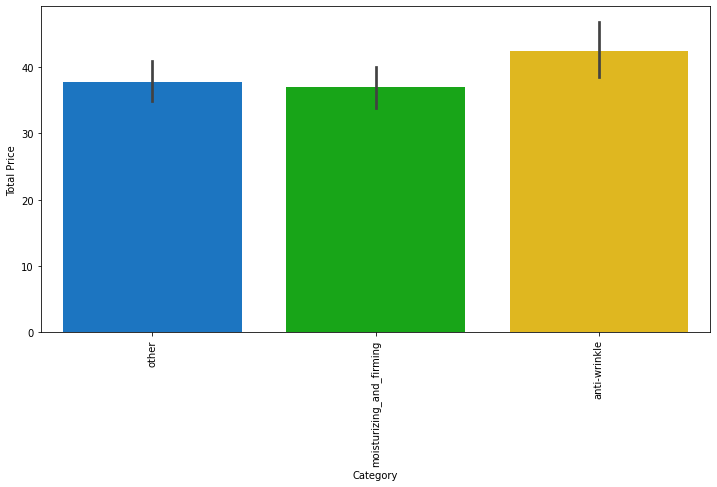

In [59]:
fig, ax = plt.subplots(figsize=(12,6))
_ = sns.barplot(x="category", y="price", data=rossmann,
                palette="nipy_spectral", ax=ax)
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
_ = ax.set(xlabel="Category", ylabel="Total Price")

**What category is with the highest income value**

In [60]:
price_sorted_category = pd.pivot_table(rossmann, index=['category'], values=['price'], aggfunc=['sum']).reset_index()
price_sorted_category.columns = ['category', 'price']
price_sorted_category = price_sorted_category.sort_values(['price'], ascending = False)
price_sorted_category

,category,price
2,other,7349.85
1,moisturizing_and_firming,5689.16
0,anti-wrinkle,2876.32


**What product=series is with the highest income value**

In [61]:
price_sorted_category = pd.pivot_table(rossmann, index=['series'], values=['price'], aggfunc=['sum']).reset_index()
price_sorted_category.columns = ['series', 'price']
price_sorted_category = price_sorted_category.sort_values(['price'], ascending = False)
price_sorted_category = price_sorted_category.head(10)
price_sorted_category

,series,price
1,@NO_NAME@,3150.05
113,SupremeLab,370.95
92,Q10 Power,364.93
71,Luxury Gold 24K Total Benefit,359.97
105,Siła Nici Kosmetycznych Forte,335.94
69,Luxury Caviar,299.96
4,Age Perfect Cell Renew,254.97
108,Smart,249.96
8,Anti-Aging,242.94
74,Mesotherapist,239.98


**What is the Brand with the most sales**

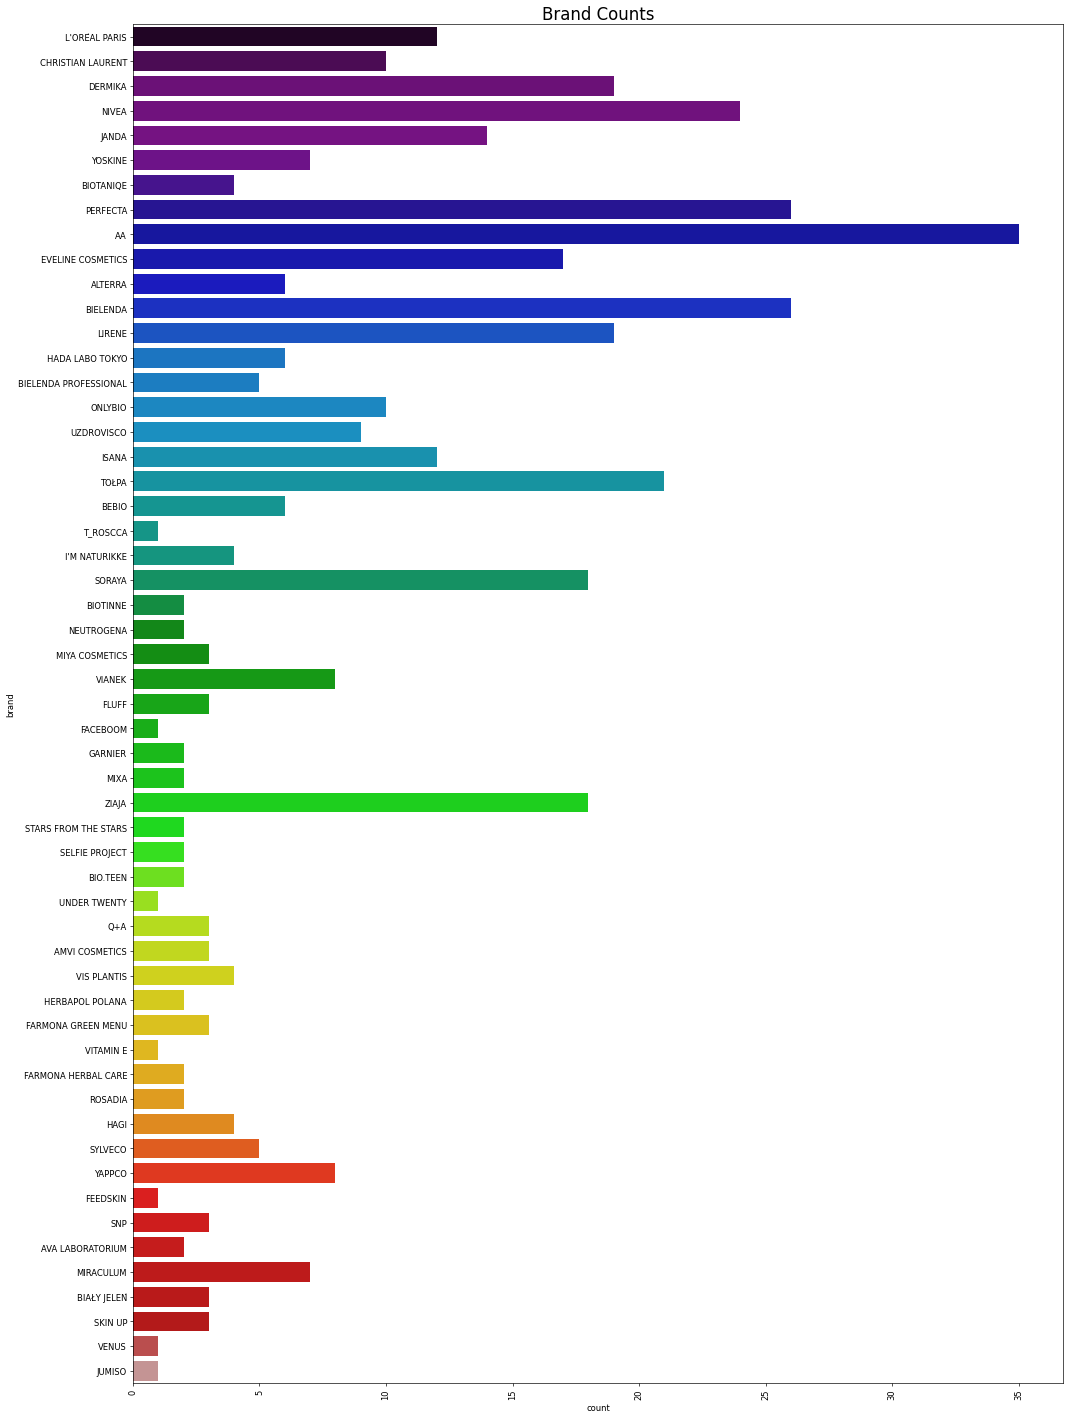

In [62]:
plt.figure(figsize=(20,30),dpi=60)
plt.xticks(rotation=90)
plt.title('Brand Counts', fontsize=20)
sns.countplot(y=rossmann['brand'], palette="nipy_spectral")
plt.show()

**What cream has the highest price?**

In [63]:
expensive_cream = pd.pivot_table(rossmann, index=['info'], values=['price'], aggfunc=['max']).reset_index()
expensive_cream.columns = ['info', 'price']
expensive_cream = expensive_cream.sort_values(['price'], ascending = False)
expensive_cream = expensive_cream.head(10)
expensive_cream

,info,price
88,"krem na dzień i na noc eliksir młodości, 45+,",119.99
72,"krem liftingujący na dzień,",119.99
101,"krem na dzień i na noc stymulator młodości, ...",119.99
98,krem na dzień i na noc rekonstruktor młodośc...,119.99
142,"krem naprawczy na noc,",119.99
138,"krem na noc, redukcja zmarszczek i ujednolieni...",99.99
115,"krem na dzień rewitalizujący,",84.99
116,"krem na dzień rewitalizujący, SPF 30,",84.99
131,"krem na noc regenerujący,",84.99
223,"krem łagodzący,",83.99


**What Brand has the highest price of the cream?**

In [64]:
brand_expensive_cream = pd.DataFrame(rossmann.groupby('brand')['price'].max())  
most_expensive_cream = brand_expensive_cream.sort_values('price', ascending=False)
most_expensive_cream.head(10)

,price
brand,
DERMIKA,119.99
L'ORÉAL PARIS,99.99
SNP,83.99
NIVEA,79.99
BIELENDA PROFESSIONAL,78.99
HAGI,69.99
HADA LABO TOKYO,69.99
CHRISTIAN LAURENT,67.99
JANDA,67.99


**What are the most expensive Brands?**

In [65]:
price_cream = pd.DataFrame(rossmann.groupby('brand')['price'].mean()).round({'price':2})
most_price = price_cream.sort_values('price', ascending=False)
most_price.head(10)

,price
brand,
DERMIKA,85.88
SNP,77.32
BIELENDA PROFESSIONAL,74.19
HADA LABO TOKYO,64.82
JUMISO,62.99
HAGI,62.49
Q+A,61.32
L'ORÉAL PARIS,59.66
ROSADIA,57.49


Brands such as **Dermika**, **Bielenda Professional**, **SNP** and **Hada Labo Tokyo** which are the brands with the average price of the most expensive products.

Brand **Loreal Paris** itself is a brand that falls into top 10 with the average price of the most expensive products.

#FIRST MODEL 

In [66]:
rossmann

,link,brand,series,size,price,info,ingredients,price per 100ml,category
0,/Produkt/Kremy-do-twarzy/LOreal-Paris-Age-Perf...,L'ORÉAL PARIS,Age Perfect Cell Renew,50.0,84.99,"krem na dzień rewitalizujący, SPF 30,","aqua, glycerin, ethylhexyl salicylate, dimeth...",169.98,other
1,/Produkt/Kremy-do-twarzy/LOreal-Paris-Age-Perf...,L'ORÉAL PARIS,Age Perfect Cell Renew,50.0,84.99,"krem na dzień rewitalizujący,","aqua, glycerin, homosalate, octocrylene, ethy...",169.98,other
2,/Produkt/Kremy-do-twarzy/LOreal-Paris-Age-Perf...,L'ORÉAL PARIS,Age Perfect Cell Renew,50.0,84.99,"krem na noc regenerujący,","aqua, mineral oil, glycerin, dimethicone, squ...",169.98,moisturizing_and_firming
3,/Produkt/Kremy-do-twarzy/Christian-Laurent-Edi...,CHRISTIAN LAURENT,Edition de Luxe,50.0,67.99,diamentowy krem ujędrniająco-odmładzający n...,"aqua, glycerin, snail secretion filtrate, isop...",135.98,moisturizing_and_firming
4,/Produkt/Kremy-do-twarzy/Dermika-Luxury-Caviar...,DERMIKA,Luxury Caviar,50.0,74.99,krem wypełniający zmarszczki na dzień i na n...,"aqua, glycerin, cocos nucifera oil, canola oil...",149.98,anti-wrinkle
...,...,...,...,...,...,...,...,...,...
412,/Produkt/Kremy-do-twarzy/Ziaja-Remodeling-krem...,ZIAJA,Remodeling,50.0,18.99,"krem na noc, ujędrniająco-odżywczy koryguja...","aqua, butylene glycol dicaprylate/dicaprate, g...",37.98,moisturizing_and_firming
413,/Produkt/Kremy-do-twarzy/Ziaja-krem-nawilzajac...,ZIAJA,@NO_NAME@,50.0,9.29,"krem nawilżający do każdego rodzaju skóry,...","aqua, glycerin, mineral oil, isopropyl myrista...",18.58,other
414,/Produkt/Kremy-do-twarzy/Ziaja-krem-tlusty-odz...,ZIAJA,@NO_NAME@,50.0,6.19,"krem tłusty, odżywczy każdy rodzaj cery dojr...","aqua, mineral oil, isohexadecane, glycerin, di...",12.38,moisturizing_and_firming
415,/Produkt/Kremy-do-twarzy/Venus-Modna-Receptura...,VENUS,Modna Receptura Glinki,50.0,11.99,krem korygujący na dzień skóra z niedoskona...,", acrylates copolymer, vp/polycarbomyl polygly...",23.98,other


I will train the model on raw text without removing stop words and without regularization.
In my data the text is a short description of the product (the name of cream).

The "category" column I added myself after matching the words to a given category, so the model can have high precision and accuracy. Let's see.

I will also create a model that matches the ingredients to the cream category.

 I will vizualize ingredients of creams using a word map.

#Train and Test split

In [67]:
X = rossmann['info']
y = rossmann['category']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


X1 = rossmann['ingredients']
y = rossmann['category']
X1_train, X1_test, y_train, y_test = train_test_split(X1, y, test_size=0.3, random_state=42)

# Logistic Regression

In [68]:
tfidf = TfidfVectorizer()
tfidf.fit(X_train)

tfidf1 = TfidfVectorizer()
tfidf1.fit(X1_train)

TfidfVectorizer()

In [69]:
tfidf.get_params()

{'analyzer': 'word',
 'binary': False,
 'decode_error': 'strict',
 'dtype': numpy.float64,
 'encoding': 'utf-8',
 'input': 'content',
 'lowercase': True,
 'max_df': 1.0,
 'max_features': None,
 'min_df': 1,
 'ngram_range': (1, 1),
 'norm': 'l2',
 'preprocessor': None,
 'smooth_idf': True,
 'stop_words': None,
 'strip_accents': None,
 'sublinear_tf': False,
 'token_pattern': '(?u)\\b\\w\\w+\\b',
 'tokenizer': None,
 'use_idf': True,
 'vocabulary': None}

In [70]:
tfidf1.get_params()

{'analyzer': 'word',
 'binary': False,
 'decode_error': 'strict',
 'dtype': numpy.float64,
 'encoding': 'utf-8',
 'input': 'content',
 'lowercase': True,
 'max_df': 1.0,
 'max_features': None,
 'min_df': 1,
 'ngram_range': (1, 1),
 'norm': 'l2',
 'preprocessor': None,
 'smooth_idf': True,
 'stop_words': None,
 'strip_accents': None,
 'sublinear_tf': False,
 'token_pattern': '(?u)\\b\\w\\w+\\b',
 'tokenizer': None,
 'use_idf': True,
 'vocabulary': None}

In [71]:
X_train_tf = tfidf.transform(X_train)
X_test_tf = tfidf.transform(X_test)

X1_train_tf = tfidf1.transform(X1_train)
X1_test_tf = tfidf1.transform(X1_test)

In [72]:
X_train_tf

<291x305 sparse matrix of type '<class 'numpy.float64'>'
	with 2284 stored elements in Compressed Sparse Row format>

In [73]:
X1_train_tf

<291x1458 sparse matrix of type '<class 'numpy.float64'>'
	with 17556 stored elements in Compressed Sparse Row format>

In [74]:
lr = LogisticRegression()
lr.fit(X_train_tf, y_train)

lr1 = LogisticRegression()
lr1.fit(X1_train_tf, y_train)


LogisticRegression()

In [75]:
y_pred = lr.predict(X_test_tf)

y1_pred = lr1.predict(X1_test_tf)

In [76]:

print(classification_report(y_test, y_pred))

print(classification_report(y_test, y1_pred))

                          precision    recall  f1-score   support

            anti-wrinkle       1.00      0.80      0.89        25
moisturizing_and_firming       0.93      0.84      0.88        45
                   other       0.83      0.96      0.89        56

                accuracy                           0.89       126
               macro avg       0.92      0.87      0.89       126
            weighted avg       0.90      0.89      0.89       126

                          precision    recall  f1-score   support

            anti-wrinkle       0.75      0.24      0.36        25
moisturizing_and_firming       0.49      0.49      0.49        45
                   other       0.59      0.77      0.67        56

                accuracy                           0.56       126
               macro avg       0.61      0.50      0.51       126
            weighted avg       0.59      0.56      0.54       126



**Check train score**

In [77]:
lr.score(X_train_tf, y_train).round(2)

0.98

In [78]:
lr1.score(X1_train_tf, y_train).round(2)

0.84

**Check test score**

In [79]:
lr.score(X_test_tf, y_test).round(2)

0.89

In [80]:
lr1.score(X1_test_tf, y_test).round(2)

0.56

In [81]:
word_info = ['krem na dzień rewitalizujący, SPF 30,']
word_info_trans = tfidf.transform(word_info)
lr.predict(word_info_trans)

array(['other'], dtype=object)

In [82]:
word_info = ['krem na noc regenerujący']
word_info_trans = tfidf.transform(word_info)
lr.predict(word_info_trans)

array(['moisturizing_and_firming'], dtype=object)

In [83]:
word_ingredients = ['oil mineral']
word_ingredients_trans = tfidf.transform(word_ingredients)
lr.predict(word_ingredients_trans)

array(['other'], dtype=object)

In [84]:
word_ingredients = ['hyaluronate']
word_ingredients_trans = tfidf.transform(word_ingredients)
lr.predict(word_ingredients_trans)

array(['other'], dtype=object)

# Random Forest

In [85]:
rfc = RandomForestClassifier()
rfc.fit(X_train_tf, y_train)

rfc1 = RandomForestClassifier()
rfc1.fit(X1_train_tf, y_train)

RandomForestClassifier()

In [86]:
y_pred = rfc.predict(X_test_tf)

y1_pred = rfc1.predict(X1_test_tf)

In [87]:
print(classification_report(y_test, y_pred))

print(classification_report(y_test, y1_pred))

                          precision    recall  f1-score   support

            anti-wrinkle       0.95      0.84      0.89        25
moisturizing_and_firming       0.89      0.87      0.88        45
                   other       0.87      0.93      0.90        56

                accuracy                           0.89       126
               macro avg       0.90      0.88      0.89       126
            weighted avg       0.89      0.89      0.89       126

                          precision    recall  f1-score   support

            anti-wrinkle       0.58      0.28      0.38        25
moisturizing_and_firming       0.46      0.49      0.47        45
                   other       0.58      0.68      0.62        56

                accuracy                           0.53       126
               macro avg       0.54      0.48      0.49       126
            weighted avg       0.54      0.53      0.52       126



In [88]:
important_features = pd.Series(data=rfc.feature_importances_,index=tfidf.get_feature_names())
important_features.sort_values(ascending=False,inplace=True)
important_features.head(40)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


przeciwzmarszczkowy    0.112598
odz                    0.058850
regeneruja             0.055752
cy                     0.048789
liftinguja             0.046090
noc                    0.041768
krem                   0.041614
na                     0.038930
ywczy                  0.034021
zmarszczki             0.031768
dzien                  0.031147
60                     0.023084
aja                    0.021262
70                     0.021256
nawilz                 0.020216
uje                    0.020028
drniaja                0.017562
50                     0.017135
odbudowuja             0.014278
redukuja               0.010774
cera                   0.009034
do                     0.007695
witamina               0.007479
2w1                    0.006319
wygładzaja             0.006082
wypełniaja             0.005997
40                     0.005844
serum                  0.005464
nawadniaja             0.005448
silnie                 0.005429
rewitalizuja           0.005174
dy      

In [89]:
important_features = pd.Series(data=rfc1.feature_importances_,index=tfidf1.get_feature_names())
important_features.sort_values(ascending=False,inplace=True)
important_features.head(40)

alcohol               0.011355
glyceryl              0.011187
gum                   0.010072
palmitate             0.009400
oil                   0.009332
glycerin              0.009112
caprylic              0.009022
cetearyl              0.009001
butyrospermum         0.008952
citrate               0.008882
acid                  0.008676
prunus                0.008630
parfum                0.008242
sodium                0.008143
aqua                  0.008073
acetate               0.007744
tocopheryl            0.007576
acrylates             0.007164
caprylyl              0.006916
stearate              0.006647
disodium              0.006508
cinnamal              0.006508
extract               0.006496
soja                  0.006477
butter                0.006457
alpha                 0.006415
hydrolyzed            0.006070
seed                  0.006035
tocopherol            0.005957
propanediol           0.005882
ionone                0.005862
parkii                0.005843
phenoxye

##**WORD MAP**

In [90]:
text = rossmann.ingredients[0]
text

' aqua, glycerin, ethylhexyl salicylate, dimethicone, octocrylene, butyl methoxydibenzoylmethane, cetyl alcohol, octyldodecanol, phenylbenzimidazole sulfonic acid, ethylhexyl triazone, behenyl alcohol, isopropyl isostearate, triethanolamine, perlite, aluminum starch octenylsuccinate, lauroyl lysine, tuber aestivum extract, tuber honey, adenosine, capryloyl salicylic acid, hydroxyacetophenone, neohesperidin dihydrochalcone, saccharomyces/xylinum/black tea ferment, sodium hyaluronate, trisodium ethylenediamine disuccinate, tocopherol, acrylamide/sodium acryloyldimethyltaurate copolymer, ammonium polyacryloyldimethyl taurate, biotin, cetearyl alcohol, cetearyl glucoside, citric acid, dimethyl isosorbide, hydroxyethyl acrylate/sodium acryloyldimethyl taurate copolymer, hydroxyethylcellulose, isohexadecane, myristic acid, palmitic acid, peg-100 stearate, poly c10-30 alkyl acrylate, polysorbate 60, polysorbate 80, propylene glycol, sodium citrate, sodium polyacrylate starch, sodium stearoyl 

In [91]:
text = " ".join(x for x in rossmann.ingredients)
print("There are {} words in the combination of all ingredients.".format(len(text)))

There are 279421 words in the combination of all ingredients.


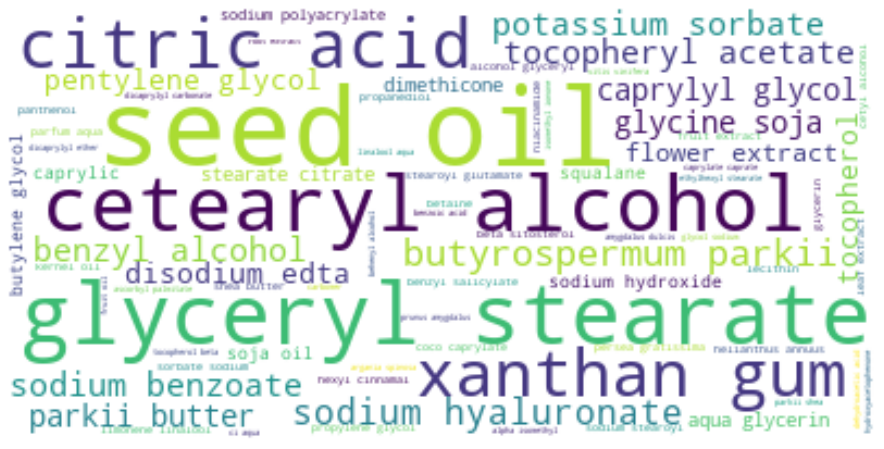

In [92]:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
plt.figure(figsize=(16, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [93]:
# Save the image:
wordcloud.to_file("cream_ingredients.png")

#SECOND MODEL

I'm going to create a content-based recommendation system where the 'content' will be the chemical components of cosmetics and their price.  I will process ingredients list  face creams on Rossmann  via word embedding, then visualize ingredients similarity using a machine learning method called t-SNE and an interactive visualization library called Bokeh.
Additionally I will vizualize the similarity of  creams using a cluster hierarchy.

#Tokenizing the ingredients

 The first step will be tokenizing the list of ingredients in the Ingredients column. After splitting them into tokens, I will make a binary bag of words. Then I will create a dictionary with the tokens, ingredient_idx:

In [94]:
rossmann

,link,brand,series,size,price,info,ingredients,price per 100ml,category
0,/Produkt/Kremy-do-twarzy/LOreal-Paris-Age-Perf...,L'ORÉAL PARIS,Age Perfect Cell Renew,50.0,84.99,"krem na dzień rewitalizujący, SPF 30,","aqua, glycerin, ethylhexyl salicylate, dimeth...",169.98,other
1,/Produkt/Kremy-do-twarzy/LOreal-Paris-Age-Perf...,L'ORÉAL PARIS,Age Perfect Cell Renew,50.0,84.99,"krem na dzień rewitalizujący,","aqua, glycerin, homosalate, octocrylene, ethy...",169.98,other
2,/Produkt/Kremy-do-twarzy/LOreal-Paris-Age-Perf...,L'ORÉAL PARIS,Age Perfect Cell Renew,50.0,84.99,"krem na noc regenerujący,","aqua, mineral oil, glycerin, dimethicone, squ...",169.98,moisturizing_and_firming
3,/Produkt/Kremy-do-twarzy/Christian-Laurent-Edi...,CHRISTIAN LAURENT,Edition de Luxe,50.0,67.99,diamentowy krem ujędrniająco-odmładzający n...,"aqua, glycerin, snail secretion filtrate, isop...",135.98,moisturizing_and_firming
4,/Produkt/Kremy-do-twarzy/Dermika-Luxury-Caviar...,DERMIKA,Luxury Caviar,50.0,74.99,krem wypełniający zmarszczki na dzień i na n...,"aqua, glycerin, cocos nucifera oil, canola oil...",149.98,anti-wrinkle
...,...,...,...,...,...,...,...,...,...
412,/Produkt/Kremy-do-twarzy/Ziaja-Remodeling-krem...,ZIAJA,Remodeling,50.0,18.99,"krem na noc, ujędrniająco-odżywczy koryguja...","aqua, butylene glycol dicaprylate/dicaprate, g...",37.98,moisturizing_and_firming
413,/Produkt/Kremy-do-twarzy/Ziaja-krem-nawilzajac...,ZIAJA,@NO_NAME@,50.0,9.29,"krem nawilżający do każdego rodzaju skóry,...","aqua, glycerin, mineral oil, isopropyl myrista...",18.58,other
414,/Produkt/Kremy-do-twarzy/Ziaja-krem-tlusty-odz...,ZIAJA,@NO_NAME@,50.0,6.19,"krem tłusty, odżywczy każdy rodzaj cery dojr...","aqua, mineral oil, isohexadecane, glycerin, di...",12.38,moisturizing_and_firming
415,/Produkt/Kremy-do-twarzy/Venus-Modna-Receptura...,VENUS,Modna Receptura Glinki,50.0,11.99,krem korygujący na dzień skóra z niedoskona...,", acrylates copolymer, vp/polycarbomyl polygly...",23.98,other


In [95]:
ingredient_list = {}
corpus = []
idx = 0

for i in range(len(rossmann['ingredients'])):
    tokens = rossmann['ingredients'][i].split(', ')
    corpus.append(tokens)
    for ingredient in tokens:
      if ingredient not in ingredient_list:
         ingredient_list[ingredient] = idx
         idx += 1

# Check the result 
print("The index for mineral oil is", ingredient_list['mineral oil'])

The index for mineral oil is 84


**Creating  matrix**

Empty matrix filled with zeros. The length of the matrix is the total number of cosmetic products in the data. The width of the matrix is the total number of ingredients.

In [96]:
M = len(rossmann['ingredients'])  
N = len(ingredient_list)

# Initialize a matrix of zeros
A = np.zeros([M,N])

In [97]:
A

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [98]:
M

417

In [99]:
N

2065

**Creating a counter function**

Before I can fill the matrix, I create a function to count the tokens (i.e., an ingredients list) for each row. My end goal is to fill the matrix with 1 or 0: if an ingredient is in a cosmetic, the value is 1. If not, it remains 0. 

In [100]:
def oh_encoder(tokens):
    x = np.zeros(N)
    for ingredient in tokens:
        idx = ingredient_list[ingredient]
        x[idx] = 1           # Put 1 at the corresponding indices
    return x

**The Cosmetic-Ingredient matrix**

This is one-hot encoding. By encoding each ingredient in the items, the Cosmetic-Ingredient matrix will be filled with binary values.

In [101]:
i = 0
for tokens in corpus:
    A[i, :] = oh_encoder(tokens)
    i+=1

In [102]:
A

array([[1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 1., 1., 1.]])

**Dimension reduction with t-SNE**

In [103]:
model = TSNE(n_components=2,learning_rate=200,random_state=42)
tsne_features = model.fit_transform(A)

# Make X, Y columns 
rossmann ['X'] = tsne_features[:,0]
rossmann ['Y'] = tsne_features[:,1]

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


**Source and scatter plot**

In [201]:
source = ColumnDataSource(rossmann)

output_file(filename="Cream.html", mode='cdn')

plot = figure(x_axis_label = "T-SNE 1", 
              y_axis_label = "T-SNE 2", 
              width = 700, height = 500,
              title= "Cream comparison")
plot.title_location='above'
plot.title.text_font_size = "25px"
plot.circle(x = "X", 
    y = "Y", 
    source = source, 
    size = 10, color = '#FF7373', alpha = .8)

GlyphRenderer(id='6310', ...)

In [202]:
hover = HoverTool(tooltips = [('Item','@info'),
                              ('Brand','@brand'),
                              ('Price','zł@price')])
                            
plot.add_tools(hover)

In [ ]:
#save(plot)

In [204]:
show(plot)

In [226]:
from bokeh.resources import CDN
from bokeh.embed import file_html


html = file_html(plot, CDN, "Cream.html")

In [227]:
html

'\n\n\n\n<!DOCTYPE html>\n<html lang="en">\n  \n  <head>\n    \n      <meta charset="utf-8">\n      <title>Cream.html</title>\n      \n      \n        \n          \n        \n        \n          \n        <script type="text/javascript" src="https://cdn.bokeh.org/bokeh/release/bokeh-2.3.3.min.js" integrity="sha384-dM3QQsP+wXdHg42wTqW85BjZQdLNNIXqlPw/BgKoExPmTG7ZLML4EGqLMfqHT6ON" crossorigin="anonymous"></script>\n        <script type="text/javascript">\n            Bokeh.set_log_level("info");\n        </script>\n        \n      \n      \n    \n  </head>\n  \n  \n  <body>\n    \n      \n        \n          \n          \n            \n              <div class="bk-root" id="413a0605-b8a7-4fcd-909e-515568bbdf7f" data-root-id="6274"></div>\n            \n          \n        \n      \n      \n        <script type="application/json" id="7053">\n          {"1eab23a2-4e0b-4c1e-b670-7aaaaad7d039":{"defs":[],"roots":{"references":[{"attributes":{},"id":"6297","type":"ResetTool"},{"attributes":{},

**Comparing two products**

Looking at the graph above we can see that if the points overlap or are very close to each other, you can visually tell that these creams have a similar or identical composition.

 Say we want to buy FEEDSKIN "Occlusive face cream" (okluzyjny krem do twarzy). We could find this product on the plot [T-SNE 1 (x=14) and T-SNE 2 (y=-8)]  and see if a similar product(s) exist. We see VIANEK's  "Normalizing day cream, oily and normal skin"(krem normalizujący na dzień, cera tłusta i normalna) essentially overlaps with the FEEDSKIN product.Additionally VIANEK's version is cheaper by 16 PLN.

 It's not perfect, but it's useful. In real life, we can actually use our little ingredient-based recommendation engine help us make educated cosmetic purchase choices.

 **I'm comparing this creams :**

*   "Occlusive face cream" (okluzyjny krem do twarzy) brands FEEDSKIN
*   "Normalizing day cream, oily and normal skin"(krem normalizujący na dzień, cera tłusta i normalna) brands VIANEK

Let see if they have a similar composition.

In [152]:
face_cream_1 = rossmann[rossmann['brand']=='FEEDSKIN'].set_index(['brand'])

pd.set_option('max_colwidth', None)                             #wyświetla całą zawartość kolumny = poszerza kolumnę
pd.set_option('max_seq_item', None)                             #wyświetla wszystko (całą iterację) zawartą w kolumnie w kadłubie(w wierszu)
face_cream_1[['info', 'ingredients', 'price per 100ml']].head()

,info,ingredients,price per 100ml
brand,,,
FEEDSKIN,"okluzyjny krem do twarzy,","aqua, cannabis sativa (hemp) seed oil, squalane, simmondsia chinensis seed oil, butyrospermum parkii butter, sorbitan stearate, sucrose cocoate, glyceryl stearate, lecithin, stearic acid, tocopheryl acetate, cetearyl alcohol, xanthan gum, benzyl alcohol, dehydroacetic acid,",97.98


In [153]:
face_cream_1['info'][0]

'okluzyjny krem do twarzy, '

In [154]:
face_cream_1.iloc[[0],[4,5,6]]

,info,ingredients,price per 100ml
brand,,,
FEEDSKIN,"okluzyjny krem do twarzy,","aqua, cannabis sativa (hemp) seed oil, squalane, simmondsia chinensis seed oil, butyrospermum parkii butter, sorbitan stearate, sucrose cocoate, glyceryl stearate, lecithin, stearic acid, tocopheryl acetate, cetearyl alcohol, xanthan gum, benzyl alcohol, dehydroacetic acid,",97.98


In [155]:
face_cream_2 = rossmann[rossmann['brand']=='VIANEK'].set_index(['brand'])

pd.set_option('max_colwidth', None) 
pd.set_option('max_seq_item', None)  

face_cream_2[['info', 'ingredients', 'price per 100ml']].head()

,info,ingredients,price per 100ml
brand,,,
VIANEK,"krem nawilżający na dzień, cera sucha i wrażliwa,","aqua, vitis vinifera seed oil, triticum vulgare germ oil, xylitol, sorbitan stearate, sucrose cocoate, urea, coco-caprylate, glycerin, taraxacum officinale leaf extract, glyceryl stearate, stearic acid, cetearyl alcohol, xanthan gum, hydrolyzed wheat protein, tocopheryl acetate, benzyl alcohol, parfum, dehydroacetic acid,",67.98
VIANEK,"krem intensywnie nawilżający na noc, cera sucha i wrażliwa,","aqua, glycine soja oil, urea, triticum vulgare germ oil, sorbitan stearate, sucrose cocoate, glycerin, argania spinosa kernel oil, robinia pseudoacacia flower extract, glyceryl stearate, coco-caprylate, stearic acid, cetearyl alcohol, xanthan gum, sodium lactate, sodium hyaluronate, tocopheryl acetate, benzyl alcohol, parfum, dehydroacetic acid,",67.98
VIANEK,"krem wzmacniający na dzień, cera naczynkowa,","aqua, vitis vinifera seed oli, zinc oxide, glycerin, sorbitan stearate, sucrose cocoate, prunus amygdalus dulcis oli, cococapryiate, ribes nigrum seed oil, glyceryl stearate, vaccinium vitis-idaea fruit extract, stearic acid, allantoin, cetearyl alcohol, xanthan gum, tocopheryl acetate, phytic acid, cl 77288, benzyl alcohol, dehydroacetic acid, parfum,",73.98
VIANEK,"krem wzmacniający na noc, cera naczynkowa,","aqua, prunus amygdalus dulcis oil, sorbitan stearate, sucrose cocate, potassium azelaoyl diglycinate, glycerin, squalane, aesculus hippocastanum seed extract, glyceryl stearate, ribes nigrum seed oil, coco-caprylate, panthenol, stearic acid, cetearyl alcohol, allantoin, tocopheryl acetate, xanthan gum, phytic acid, benzyl alcohol, dehydroacetic acid, parfum,",73.98
VIANEK,"krem normalizujący na dzień, cera tłusta i normalna,","aqua, vitis vinifera seed oil, olea europaea fruit oil, zea mays starch, sorbitan stearate, sucrose cocoate, squalane, glyceryl stearate, salix alba bark extract, stearic acid, cetearyl alcohol, niacinamide, tocopheryl acetate, xanthan gum, benzyl alcohol, parfum, mentha piperita oil, dehydroacetic acid, limonene,",65.98


In [156]:
face_cream_2['info']

brand
VIANEK             krem nawilżający na dzień, cera sucha i wrażliwa, 
VIANEK    krem intensywnie nawilżający na noc, cera sucha i wrażliwa, 
VIANEK                    krem wzmacniający na dzień, cera naczynkowa, 
VIANEK                       krem wzmacniający na noc, cera naczynkowa, 
VIANEK            krem normalizujący na dzień, cera tłusta i normalna, 
VIANEK               krem normalizujący na noc, cera tłusta i normalna, 
VIANEK                     krem odżywczy na dzień, każdy rodzaj cery, 
VIANEK            krem intensywnie odżywczy na noc, każdy rodzaj cery, 
Name: info, dtype: object

In [157]:
face_cream_2['info'][4]

'krem normalizujący na dzień, cera tłusta i normalna, '

In [158]:
face_cream_2.iloc[[4],[4,5,6]]

,info,ingredients,price per 100ml
brand,,,
VIANEK,"krem normalizujący na dzień, cera tłusta i normalna,","aqua, vitis vinifera seed oil, olea europaea fruit oil, zea mays starch, sorbitan stearate, sucrose cocoate, squalane, glyceryl stearate, salix alba bark extract, stearic acid, cetearyl alcohol, niacinamide, tocopheryl acetate, xanthan gum, benzyl alcohol, parfum, mentha piperita oil, dehydroacetic acid, limonene,",65.98


**TWO SIMILAR COSMETICS**

In [159]:
face_cream_1.iloc[[0],[4,5,6]]

,info,ingredients,price per 100ml
brand,,,
FEEDSKIN,"okluzyjny krem do twarzy,","aqua, cannabis sativa (hemp) seed oil, squalane, simmondsia chinensis seed oil, butyrospermum parkii butter, sorbitan stearate, sucrose cocoate, glyceryl stearate, lecithin, stearic acid, tocopheryl acetate, cetearyl alcohol, xanthan gum, benzyl alcohol, dehydroacetic acid,",97.98


In [160]:
face_cream_2.iloc[[4],[4,5,6]]

,info,ingredients,price per 100ml
brand,,,
VIANEK,"krem normalizujący na dzień, cera tłusta i normalna,","aqua, vitis vinifera seed oil, olea europaea fruit oil, zea mays starch, sorbitan stearate, sucrose cocoate, squalane, glyceryl stearate, salix alba bark extract, stearic acid, cetearyl alcohol, niacinamide, tocopheryl acetate, xanthan gum, benzyl alcohol, parfum, mentha piperita oil, dehydroacetic acid, limonene,",65.98


**CONCLUSION:**

It can be said that the above creams have very similar composition and the cream by VIANEK is cheaper.

#CLUSTER HIERARCHY

In [161]:
rossmann_clust_1 = A[:100]

In [162]:
index_rossmann_clust_1 = (rossmann['brand']+rossmann['series']).iloc[:100]
index_rossmann_clust_1

0     L'ORÉAL PARISAge Perfect Cell Renew
1     L'ORÉAL PARISAge Perfect Cell Renew
2     L'ORÉAL PARISAge Perfect Cell Renew
3         CHRISTIAN LAURENTEdition de Luxe
4                     DERMIKALuxury Caviar
                      ...                 
95                       PERFECTABotu-Line
96                       PERFECTABotu-Line
97                       PERFECTABotu-Line
98                     PERFECTABio Kolagen
99             NIVEACellular Expert Filler
Length: 100, dtype: object

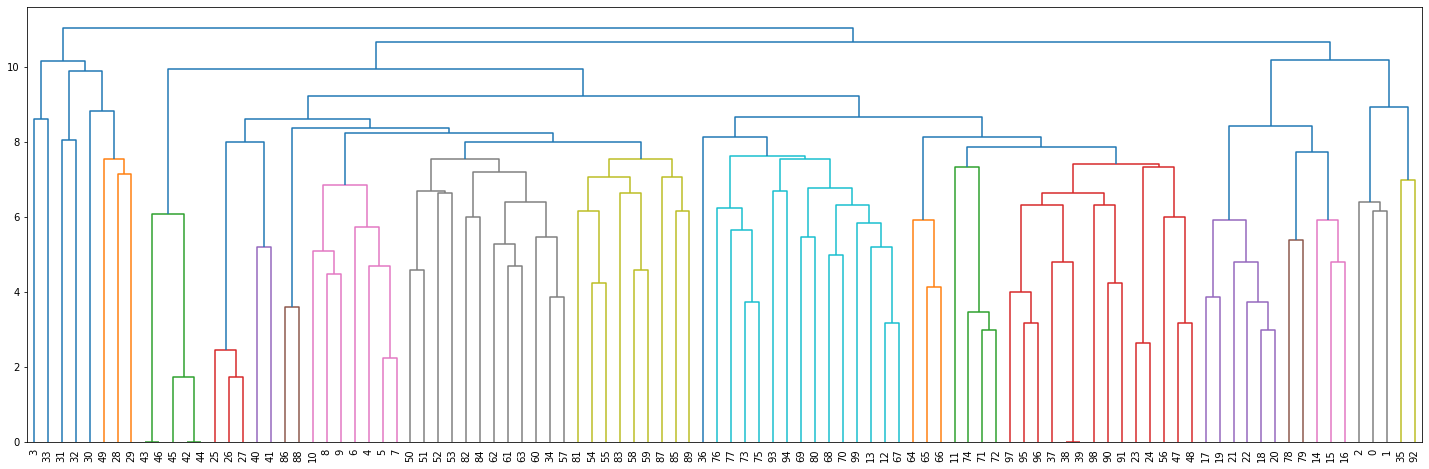

In [163]:
from scipy.cluster.hierarchy import linkage, dendrogram

# Calculate the linkage: mergings
mergings = linkage(rossmann_clust_1, method='complete')

# Plot the dendrogram, using varieties as labels


fig, ax = plt.subplots(figsize = (25,8))
dendrogram(mergings,
           labels =None,
           leaf_rotation=90,
           leaf_font_size=10,
            )
plt.show()

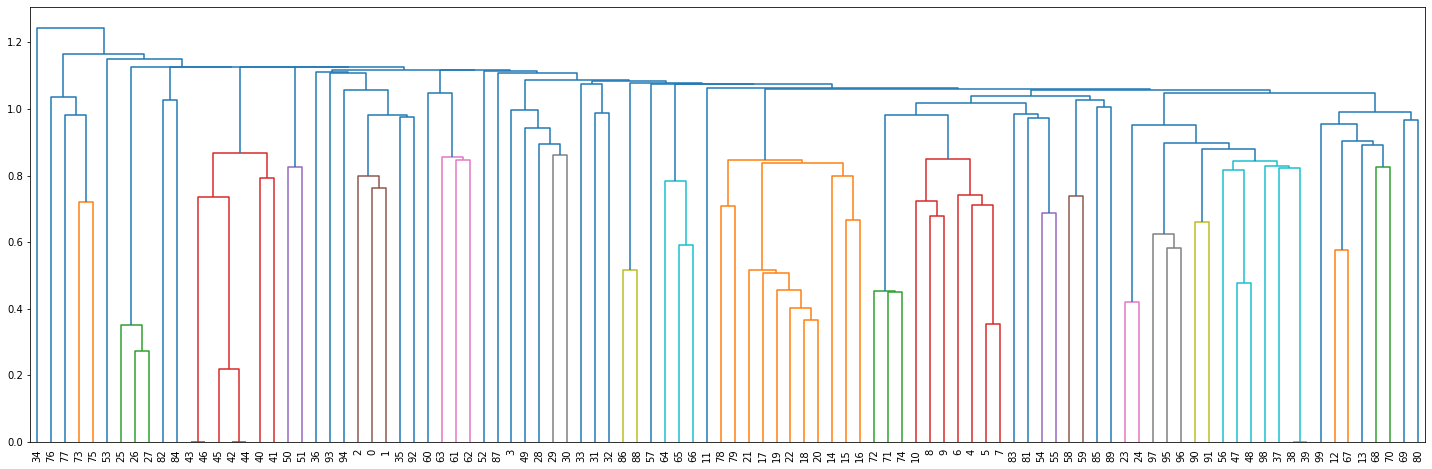

In [164]:
from sklearn.preprocessing import normalize
normalized_df = normalize(rossmann_clust_1)
mergings = linkage(normalized_df, method='single')

# Plot the dendrogram, using varieties as labels

fig, ax = plt.subplots(figsize = (25,8))
dendrogram(mergings,
           labels=None,
           leaf_rotation=90,
           leaf_font_size=10,
            )
plt.show()